We are given a model $p_\theta(x,z) = p_\theta(z) p_\theta(x|z)$, where $\theta$ are the parameters, $z$ are the latent variables, and $x$ are the observations. We wish to learn the posterior $p_{\theta^*}(z|x)$ where $\theta^*$ are parameters where the evidence $p_\theta(x)$ is maximized. To do so, we assume a distribution $q_\phi(z)$ and do variational inference. To do variational inference, we maximize evidence lower bound, or ELBO.

$ELBO = \mathbb E_{q_\phi(z)}[\log p_\theta(x,z)-\log q_\phi(z)]$

In [46]:
import torch
import pyro
import matplotlib.pyplot as plt
import tqdm
import math

### Example

Prior = $p(\theta) = Beta(10, 10)$<br>
We observe data about the coin using a Bernoulli likelihood.<br>
Likelihood = $p(X_i| \theta) = Ber(X_i; \theta)$ where $\theta \sim p(\theta)$<br>
To find the posterior, we assume a variational distribution $Beta(a,b)$

In [38]:
def model(data):
    theta = pyro.sample("theta", pyro.distributions.Beta(10., 10.))
    for i, X_i in enumerate(data):
        pyro.sample("X_%d" % i, pyro.distributions.Bernoulli(theta), obs = X_i)

In [39]:
def guide(data):
    a = pyro.param("a", torch.tensor(15.))
    b = pyro.param("b", torch.tensor(15.), constraint = torch.distributions.constraints.positive)
    pyro.sample("theta", pyro.distributions.Beta(a, b))

In [48]:
optimizer = pyro.optim.Adam({"lr": 0.0005, "betas": (0.90, 0.999)})

In [49]:
svi = pyro.infer.SVI(model, guide, optimizer, loss = pyro.infer.Trace_ELBO())

In [50]:
data = [torch.tensor(0.) for _ in range(4)] + [torch.tensor(1.) for _ in range(6)]

100%|██████████| 5000/5000 [00:34<00:00, 146.20it/s]


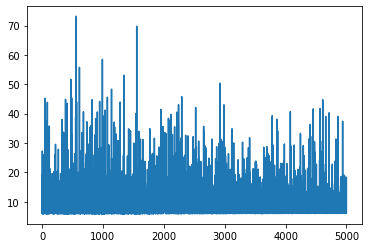

In [51]:
losses = []
for step in tqdm.tqdm(range(5000)):
    svi.step(data)
    losses += [svi.evaluate_loss(data)]
plt.plot(range(5000), losses)

In [45]:
a, b = pyro.param("a").item(), pyro.param("b").item()

In [47]:
a/(a+b), (a/(a+b))*math.sqrt(b/(a*(1+a+b)))

(0.5070804246098672, 0.25307192027316433)